<a href="https://colab.research.google.com/github/danb-neo4j/NODES2022_GraphEDA/blob/main/NODES2022_GraphEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NODES 2022 GraphEDA Workshop: 
## Notebook Three -- GraphEDA


# Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(11,6)})

import os 
import configparser

In [2]:
# install or import Neo4j GraphDataScience library
try: 
  from graphdatascience import GraphDataScience
  print('Successfully imported GraphDataScience')
except ModuleNotFoundError:
  !pip install graphdatascience
  from graphdatascience import GraphDataScience
  print('installed and imported GraphDataScience')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 6.8 MB/s 
     |████████████████████████████████| 173 kB 21.7 MB/s 
  Created wheel for neo4j: filename=neo4j-5.1.0-py3-none-any.whl size=248097 sha256=85157824ade6fde52030f6ac7ba4d1ea5baf1656f42feb28160b85c2fab8bb75
  Stored in directory: /root/.cache/pip/wheels/64/96/da/c30ec8577a970eadecc436103fbcbf7af1d6398d0ebe32cbab
Successfully built neo4j
installed and imported GraphDataScience


# Custom Functions

In [3]:
# function adapted from Neo4j GDS Fraud Demo Notebook (h/t Zach B.)
def read_neo4j_properties(NEO4J_PROPERTIES_FILE: str=None) -> str:
  '''Parses Neo4j database or Aura connection details from provided .ini filepath.
  Requirements:
    configparser

  Args:
    NEO4J_PROPERTIES_FILE: path to a .ini file
  
  Returns:
    HOST: link to Neo4j or Aura host 
    USERNAME: login username
    PASSWORD: login password 

  Note: The .ini file should use the following syntax
    [NEO4J]
    PASSWORD=<password>
    USERNAME=<database name>
    HOST=<host uri>

  If no path is passed, the function will return the defaults:
    HOST = 'neo4j://localhost'
    USERNAME = 'neo4j'
    PASSWORD = 'password'
  '''

  if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
      config = configparser.RawConfigParser()
      config.read(NEO4J_PROPERTIES_FILE)
      HOST = config['NEO4J']['HOST']
      USERNAME = config['NEO4J']['USERNAME']
      PASSWORD = config['NEO4J']['PASSWORD']
      print('Using HOST, USERNAME, PASSWORD from .ini file')
      return HOST, USERNAME, PASSWORD
  else:
      print('Could not find database properties file, using defaults:')
      HOST = 'neo4j://localhost'
      USERNAME = 'neo4j'
      PASSWORD = 'password'
      print(f'HOST: {HOST} \nUSERHAME: {USERNAME} \nPASSWORD: {PASSWORD}')
      return HOST, USERNAME, PASSWORD 

In [4]:
def gen_graph_counts(df: pd.DataFrame) -> None:
  '''return count columns from output of apoc.meta.stats()

  Args:
    df: dataframe containing output of apoc.meta.stats()

  Returns:
    print count columns to notebook 
  '''

  print(summary_df[['nodeCount', 'labelCount', 'propertyKeyCount', 'relCount', 'relTypeCount']].T)

In [5]:
def gen_nodeLabel_count(summary_df: pd.DataFrame) -> None:
  '''import summary_df and return dataframe with node label count
  args:
    summary_df: dataframe returned from apoc.meta.stats()
  
  returns:
    Nothing; will print the dataframe to the notebook
  '''
  # generate a new dataframe from the nested dictionary in the 'labels' column
  labels_df = pd.DataFrame(summary_df['labels']['values'].items()).set_index(0)

  # rename the index and column
  labels_df.columns = ['nodeCount']
  labels_df.index.rename('nodeLabel', inplace=True)

  # sort by descending count 
  labels_df.sort_values(by='nodeCount', ascending=False, inplace=True)
  print(labels_df)

In [6]:
def gen_nodeLabel_properties() -> None:
  '''cypher call for properties; return node properties table
  args:
    None

  returns:
    Nothing; prints dataframe to notebook
  '''
  # query for nodeProperty schema dataframe 
  node_properties_df = gds.run_cypher('''CALL db.schema.nodeTypeProperties()''')

  # remove extra text from nodeType column and sort
  node_properties_df['nodeType'] = node_properties_df['nodeType'].str.replace('`', '')
  node_properties_df['nodeType'] = node_properties_df['nodeType'].str.replace(':', '')
  node_properties_df.sort_values(by=['nodeType', 'propertyName'], inplace=True)

  # view dimensions 
  print(node_properties_df)

In [7]:
def gen_graph_rel_patterns(summary_df: pd.DataFrame) -> None:
  '''generate list of graph relationship patterns from apoc.meta.stats()
  '''
  # extract nested dictionary into a dataframe 
  graphPatterns_df = pd.DataFrame(summary_df['relTypes']['values'].items())

  # # rename columns and set an index 
  graphPatterns_df.rename(columns = {0: 'relPattern', 1:'relCount'}, inplace=True)
  graphPatterns_df.set_index('relPattern', inplace=True)

  # sort descending
  graphPatterns_df.sort_values(by=['relCount', 'relPattern'], ascending=False, inplace=True)

  print(graphPatterns_df)

In [8]:
def gen_relType_count(summary_df: pd.DataFrame) -> None:
  '''generate relationship type count from apoc.meta.stats()
  inputs:
    summary_df: output from apoc.meta.stats()
  '''
  # generate a new dataframe from the nested dictionary in the 'labels' column
  relTypes_df = pd.DataFrame(summary_df['relTypesCount']['values'].items()).set_index(0)

  # rename the index and column
  relTypes_df.columns = ['relCount']
  relTypes_df.index.rename('relType', inplace=True)

  # sort by descending count 
  relTypes_df.sort_values(by='relCount', ascending=False, inplace=True)
  print(relTypes_df)

In [9]:
def gen_relType_properties() -> None:
  '''generate and print table of relationship properties
  inputs:
    None

  outputs:
    None; prints table to notebook
  '''
  # query for schema dataframe 
  rel_properties_df = gds.run_cypher('''CALL db.schema.relTypeProperties()''')

  # remove extra text from nodeType column
  rel_properties_df['relType'] = rel_properties_df['relType'].str.replace('`', '')
  rel_properties_df['relType'] = rel_properties_df['relType'].str.replace(':', '')

  # view dimensions 
  print(rel_properties_df.sort_values(by='relType', ascending=True))

In [10]:
def gen_apoc_stats(df: pd.DataFrame, col: str) -> None:
  '''generate statistics from an array of node degree values
  inputs:
    df: dataframe containing the degree values
    col: df column to perform the calculation on
  '''
  return round(df[col].describe(percentiles=[.25, .5, .75, .9, .95, .99]), 2)

# Connect to Colab

In [11]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
os.chdir('drive/MyDrive/Colab Notebooks/NODES_2022_Workshop/')

In [13]:
train_df = pd.read_csv("source_data/spaceshipTitanic_train_processed.csv")

print('train dataframe dimensions:', train_df.shape)

train dataframe dimensions: (8693, 21)


# Connect to AuraDS
If using a persistent AuraDS instance, it is recommended to store authentication credentials in a separate file and read them in to the notebook as variables. This code assumes the notebook is running Colab and the files are stored in a local auth directory.

In [14]:
NEO4J_PROPERTIES_FILE = 'auth/nodes_titanic_auth.ini'
HOST, USERNAME, PASSWORD = read_neo4j_properties(NEO4J_PROPERTIES_FILE=NEO4J_PROPERTIES_FILE)

Using HOST, USERNAME, PASSWORD from .ini file


In [15]:
# connect to AuraDS instance 
gds = GraphDataScience(HOST, auth=(USERNAME, PASSWORD), aura_ds=True)

In [16]:
# confirm connection with GDS version 
gds.version()

'2.2.1'

# High-Level Graph Database overview

## View Graph Database Schema in Browser
* There is no one 'right way' to perform EDA on a data set and Graph EDA is an emerging area of Graph Data Science (GDS) with few established best practices. 
* We have multiple tools available and we want to use any and all of them that can be most beneficial.
* It is always recommended to call `CALL db.schema.visualization()` on the data from the Neo4j Browser to view the data model. It will not render if called from the Python GDS client.
  * At a minimum, review the schema and confirm it passes the *common sense test* especially if you loaded the data manually. 
  * If possible, compare it to an expected model as well to identify any potential errors or other data schema issues. 


**To-Do: Upload impage of schmea to GitHub and link in notebook**

## Data Summary
Calling `apoc.meta.stats()` will yield an output (or in this case, a DataFrame) containing several high level statistics about the contents of our graph database.  

There are multiple ways we can work with this data, either in Python itself or through multiple Cypher calls to the database. However it may be preferrable for some to make one Cypher call to the database and then work with the returned DataFrame.

In [15]:
# return full dataframe of summary data 
summary_df = gds.run_cypher('''
                            CALL apoc.meta.stats()
                            YIELD *
                            ''')

# set a named index, rather than the default 0
summary_df.index = ['values']

# view dimensions of dataframe
summary_df.shape

(1, 9)

## Summary Statistics

In [16]:
summary_df

,labelCount,relTypeCount,propertyKeyCount,nodeCount,relCount,labels,relTypes,relTypesCount,stats
values,8,9,15,18904,68645,"{'CabinSide': 2, 'Group': 1412, 'Amenity': 5, 'Cabin': 6560, 'Passenger': 8693, 'Planet': 6, 'CabinDeck': 8, 'Surname': 2218}","{'()-[:ASSIGNED]->(:Cabin)': 8693, '()-[:ORIGINATED]->()': 8693, '()-[:HAS_SURNAME]->()': 8693, '()-[:ON_SIDE]->()': 6560, '(:Passenger)-[:MEMBER]->()': 3888, '()-[:ON_DECK]->(:CabinDeck)': 6560, '()-[:ON_SIDE]->(:CabinSide)': 6560, '()-[:TRAVELING]->(:Planet)': 8693, '()-[:MEMBER]->(:Group)': 3888, '()-[:SPEND]->()': 15083, '()-[:IN_GROUP]->()': 1782, '(:Passenger)-[:SPEND]->()': 15083, '()-[:HAS_SURNAME]->(:Surname)': 8693, '(:Passenger)-[:ORIGINATED]->()': 8693, '()-[:TRAVELING]->()': 8693, '(:Passenger)-[:HAS_SURNAME]->()': 8693, '()-[:ASSIGNED]->()': 8693, '()-[:MEMBER]->()': 3888, '(:Passenger)-[:TRAVELING]->()': 8693, '()-[:ORIGINATED]->(:Planet)': 8693, '()-[:IN_GROUP]->(:Group)': 1782, '(:Surname)-[:IN_GROUP]->()': 1782, '(:Cabin)-[:ON_DECK]->()': 6560, '(:Passenger)-[:ASSIGNED]->()': 8693, '(:Cabin)-[:ON_SIDE]->()': 6560, '()-[:SPEND]->(:Amenity)': 15083, '()-[:ON_DECK]->()': 6560}","{'ON_SIDE': 6560, 'IN_GROUP': 1782, 'TRAVELING': 8693, 'HAS_SURNAME': 8693, 'ASSIGNED': 8693, 'ON_DECK': 6560, 'ORIGINATED': 8693, 'SPEND': 15083, 'MEMBER': 3888}","{'relTypeCount': 9, 'propertyKeyCount': 15, 'labelCount': 8, 'nodeCount': 18904, 'relCount': 68645, 'labels': {'CabinSide': 2, 'Group': 1412, 'Amenity': 5, 'Cabin': 6560, 'Passenger': 8693, 'Planet': 6, 'CabinDeck': 8, 'Surname': 2218}, 'relTypes': {'()-[:ASSIGNED]->(:Cabin)': 8693, '()-[:ORIGINATED]->()': 8693, '()-[:HAS_SURNAME]->()': 8693, '()-[:ON_SIDE]->()': 6560, '(:Passenger)-[:MEMBER]->()': 3888, '()-[:ON_DECK]->(:CabinDeck)': 6560, '()-[:ON_SIDE]->(:CabinSide)': 6560, '()-[:TRAVELING]->(:Planet)': 8693, '()-[:MEMBER]->(:Group)': 3888, '()-[:SPEND]->()': 15083, '()-[:IN_GROUP]->()': 1782, '(:Passenger)-[:SPEND]->()': 15083, '()-[:HAS_SURNAME]->(:Surname)': 8693, '(:Passenger)-[:ORIGINATED]->()': 8693, '()-[:TRAVELING]->()': 8693, '(:Passenger)-[:HAS_SURNAME]->()': 8693, '()-[:ASSIGNED]->()': 8693, '()-[:MEMBER]->()': 3888, '(:Passenger)-[:TRAVELING]->()': 8693, '()-[:ORIGINATED]->(:Planet)': 8693, '()-[:IN_GROUP]->(:Group)': 1782, '(:Surname)-[:IN_GROUP]->()': 1782, '(:Cabin)-[:ON_DECK]->()': 6560, '(:Passenger)-[:ASSIGNED]->()': 8693, '(:Cabin)-[:ON_SIDE]->()': 6560, '()-[:SPEND]->(:Amenity)': 15083, '()-[:ON_DECK]->()': 6560}}"


## Graph Value Counts

In [19]:
gen_graph_counts(df=summary_df)

                  values
nodeCount          18904
labelCount             8
propertyKeyCount      15
relCount           68645
relTypeCount           9


# Nodes

## Node Label Count

In [20]:
# use function defined above
gen_nodeLabel_count(summary_df=summary_df)

           nodeCount
nodeLabel           
Passenger       8693
Cabin           6560
Surname         2218
Group           1412
CabinDeck          8
Planet             6
Amenity            5
CabinSide          2


## Node Label Properties

In [21]:
# use function defined above
gen_nodeLabel_properties()

     nodeType   nodeLabels propertyName propertyTypes  mandatory
7     Amenity    [Amenity]           id      [String]       True
2       Cabin      [Cabin]           id      [String]       True
4   CabinDeck  [CabinDeck]           id      [String]       True
5   CabinSide  [CabinSide]           id      [String]       True
1       Group      [Group]   Group_Size      [Double]       True
0       Group      [Group]           id        [Long]       True
9   Passenger  [Passenger]          age      [Double]       True
10  Passenger  [Passenger]    cryosleep     [Boolean]       True
8   Passenger  [Passenger]           id      [String]       True
11  Passenger  [Passenger]   totalspend      [Double]       True
12  Passenger  [Passenger]  transported     [Boolean]       True
3      Planet     [Planet]           id      [String]       True
6     Surname    [Surname]           id      [String]       True


## Delete Imputed 'SuperNodes'
The imputed value has a high count of relationships, making it an outlier that distorts our other analysis. 

In [ ]:
gds.run_cypher('''
  MATCH (s:Surname {id:'NoSurname'})
  DETACH DELETE s
''')

""


In [ ]:
gds.run_cypher('''
  MATCH (c:Cabin {id:'F999P'})
  DETACH DELETE s
''')

# Relationships

## Relationship Type Count

In [22]:
# using the summary_df 
gen_relType_count(summary_df)

             relCount
relType              
SPEND           15083
TRAVELING        8693
HAS_SURNAME      8693
ASSIGNED         8693
ORIGINATED       8693
ON_SIDE          6560
ON_DECK          6560
MEMBER           3888
IN_GROUP         1782


## Relationship Type Properties

In [23]:
gen_relType_properties()

       relType propertyName propertyTypes  mandatory
6     ASSIGNED         None          None      False
0  HAS_SURNAME         None          None      False
3     IN_GROUP         None          None      False
5       MEMBER         None          None      False
1      ON_DECK         None          None      False
2      ON_SIDE         None          None      False
4   ORIGINATED         None          None      False
7        SPEND       amount      [Double]       True
8    TRAVELING         None          None      False


## Relationship Patterns

In [26]:
gen_graph_rel_patterns(summary_df)

                                 relCount
relPattern                               
(:Passenger)-[:SPEND]->()           15083
()-[:SPEND]->(:Amenity)             15083
()-[:SPEND]->()                     15083
(:Passenger)-[:TRAVELING]->()        8693
(:Passenger)-[:ORIGINATED]->()       8693
(:Passenger)-[:HAS_SURNAME]->()      8693
(:Passenger)-[:ASSIGNED]->()         8693
()-[:TRAVELING]->(:Planet)           8693
()-[:TRAVELING]->()                  8693
()-[:ORIGINATED]->(:Planet)          8693
()-[:ORIGINATED]->()                 8693
()-[:HAS_SURNAME]->(:Surname)        8693
()-[:HAS_SURNAME]->()                8693
()-[:ASSIGNED]->(:Cabin)             8693
()-[:ASSIGNED]->()                   8693
(:Cabin)-[:ON_SIDE]->()              6560
(:Cabin)-[:ON_DECK]->()              6560
()-[:ON_SIDE]->(:CabinSide)          6560
()-[:ON_SIDE]->()                    6560
()-[:ON_DECK]->(:CabinDeck)          6560
()-[:ON_DECK]->()                    6560
(:Passenger)-[:MEMBER]->()        

# Bloom
Bloom is a fantastic graph visualization tool to quickly explore different node and relationship combinations.

We can use it for high-level exploration of nodes and relationships we did not analyze as much in tabular format:
* Cabin
* Surname
* Group

`(c:Cabin)<-[:ASSIGNED]-(p:Passenger)-[HAS_SURNAME]->(s:Surname)-[IN_GROUP]->(g:Group)`

# Path Exploration in Neo4j Browser



In [65]:
'''
MATCH x=(c:Cabin)<-[:ASSIGNED]-(p:Passenger)-[HAS_SURNAME]->(s:Surname)-[IN_GROUP]->(g:Group)
WHERE 
    s.id <> 'NoSurname' AND
    g.Group_Size > 5 AND
    p.transported=True AND
    c.id <> 'F999P'
RETURN x LIMIT 200
'''

"\nMATCH x=(c:Cabin)<-[:ASSIGNED]-(p:Passenger)-[HAS_SURNAME]->(s:Surname)-[IN_GROUP]->(g:Group)\nWHERE \n    s.id <> 'NoSurname' AND\n    g.Group_Size > 5 AND\n    p.transported=True AND\n    c.id <> 'F999P'\nRETURN x LIMIT 100\n"

# Node Degree Statistics
The objective is to calculate the in-degree or out-degree of specific node and relationship combinations. 

Can generate aggregate node statistics using multiple approaches:
* Cypher query passing the results to `apoc.agg.statistics()`
* Return array to a pandas DataFrame and pass to `.describe()`.

## (c:Cabin)<-[:ASSIGNED]-(p:Passenger)
*Excluding imputed cabin F999P*

In [28]:
# using apoc.agg.statistics()
cabin_inDegree_stats = gds.run_cypher('''
MATCH (c:Cabin)
  WHERE c.id <> 'F999P'
WITH c, 
  SIZE((c)<-[:ASSIGNED]-()) as inDegree
RETURN apoc.agg.statistics(inDegree) AS stats
''')

cabin_inDegree_stats['stats'][0]

{'total': 6559,
 'min': 1,
 'minNonZero': 1.0,
 'max': 8,
 'mean': 1.3101082482085684,
 '0.5': 1,
 '0.99': 5,
 '0.75': 1,
 '0.9': 2,
 '0.95': 3,
 'stdev': 0.8212047032751133}

In [29]:
cabin_inDegree_data = gds.run_cypher('''
  MATCH (c:Cabin)
    WHERE c.id <> 'F999P'
  WITH c 
  RETURN SIZE((c)<-[:ASSIGNED]-()) as inDegree
''')

cabin_inDegree_data.shape

(6559, 1)

In [31]:
gen_apoc_stats(df=cabin_inDegree_data, col='inDegree')

count    6559.00
mean        1.31
std         0.82
min         1.00
25%         1.00
50%         1.00
75%         1.00
90%         2.00
95%         3.00
99%         5.00
max         8.00
Name: inDegree, dtype: float64

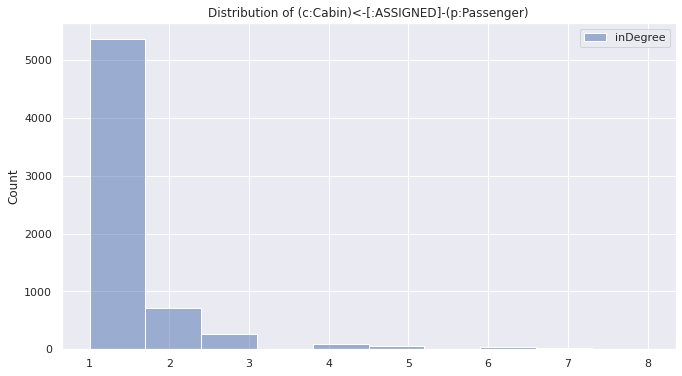

In [32]:
sns.histplot(cabin_inDegree_data, bins=10).set(title='Distribution of (c:Cabin)<-[:ASSIGNED]-(p:Passenger)')
plt.show()

## (p:Passenger)-[:HAS_SURNAME]->(s:Surname)
*Excluding imputed NoSurname*

In [33]:
passenger_surname_inDegree = gds.run_cypher('''
  MATCH (s:Surname)
    WHERE s.id <> 'NoSurname'
  WITH s 
    RETURN SIZE(()-[:HAS_SURNAME]->(s)) AS inDegree
''')

passenger_surname_inDegree.shape

(2217, 1)

In [34]:
gen_apoc_stats(df=passenger_surname_inDegree, col='inDegree')

count    2217.00
mean        3.83
std         2.47
min         1.00
25%         2.00
50%         3.00
75%         5.00
90%         7.00
95%         8.20
99%        11.00
max        18.00
Name: inDegree, dtype: float64

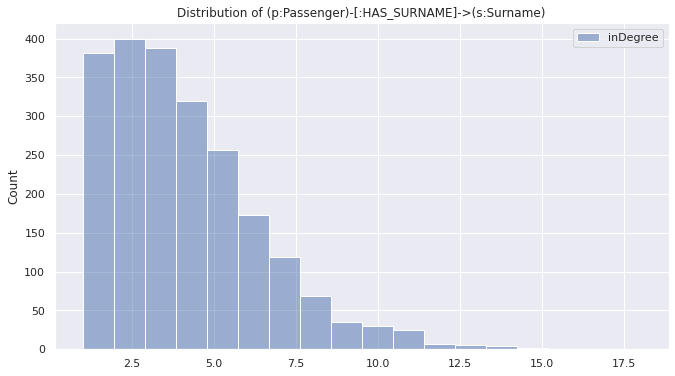

In [35]:
sns.histplot(passenger_surname_inDegree, bins=18).set(title='Distribution of (p:Passenger)-[:HAS_SURNAME]->(s:Surname)')
plt.show()

## (s:Surname)-[:IN_GROUP]->(g:Group)
*Excluding imputed NoSurname*

In [36]:
surname_group_inDegree = gds.run_cypher('''
  MATCH (g:Group)
  WITH g
    RETURN SIZE(()-[:IN_GROUP]->(g)) AS inDegree
''')

surname_group_inDegree.shape

(1412, 1)

In [37]:
gen_apoc_stats(df=surname_group_inDegree, col='inDegree')

count    1412.00
mean        1.26
std         0.52
min         1.00
25%         1.00
50%         1.00
75%         1.00
90%         2.00
95%         2.00
99%         3.00
max         4.00
Name: inDegree, dtype: float64

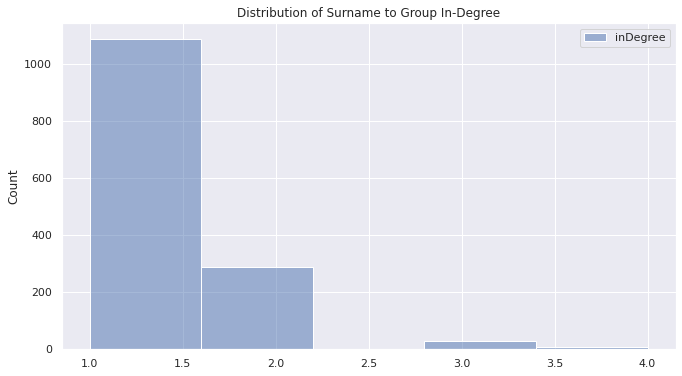

In [38]:
sns.histplot(surname_group_inDegree, bins=5).set(title='Distribution of Surname to Group In-Degree')
plt.show()

## (p:Passenger)-[:MEMBER]->(g:Group)

In [39]:
passenger_group_inDegree = gds.run_cypher('''
  MATCH (g:Group)
  WITH g 
    RETURN SIZE(()-[:MEMBER]->(g)) AS inDegree
''')

passenger_group_inDegree.shape

(1412, 1)

In [40]:
gen_apoc_stats(df=passenger_group_inDegree, col='inDegree')

count    1412.00
mean        2.75
std         1.24
min         2.00
25%         2.00
50%         2.00
75%         3.00
90%         4.00
95%         6.00
99%         7.00
max         8.00
Name: inDegree, dtype: float64

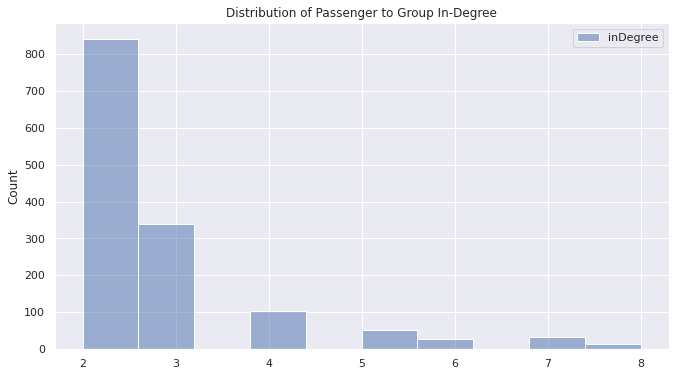

In [41]:
sns.histplot(passenger_group_inDegree, bins=10).set(title='Distribution of Passenger to Group In-Degree')
plt.show()

# Analysis of Surname Nodes

## Distinct Surnames that are in Groups

In [42]:
# count of distinct surnames that are in groups 
# groups must have 2+ members to be in the graph
gds.run_cypher('''
  MATCH (s:Surname)-[:IN_GROUP]->(g:Group)
  RETURN COUNT(DISTINCT s) AS group_surnames
''')

,group_surnames
0,1237


## Surname and Transported

In [43]:
# generate dataframe of surnames, passengers, and transported 
surname_transported_df = gds.run_cypher('''
  MATCH (p:Passenger)-[:HAS_SURNAME]->(s:Surname)
    WHERE s.id <> 'NoSurname'
  WITH 
      s.id AS surname,
      COUNT(p) AS totalPassengers,
      COUNT(CASE WHEN p.transported=True THEN 1 END) AS transported
  RETURN
      surname,
      totalPassengers,
      transported,
      ROUND(toFloat(transported)/toFloat(totalPassengers), 3) AS pct_transported
  ORDER BY totalPassengers DESC
''')
surname_transported_df.shape

(2217, 4)

In [44]:
# top five surnames sorted by transported passenger count
surname_transported_df.sort_values('transported', ascending=False).head()

,surname,totalPassengers,transported,pct_transported
3,Domington,15,14,0.933
10,Barbes,13,10,0.769
50,Moodsey,10,9,0.900
6,Browlerson,14,9,0.643
57,Mckinsond,10,9,0.900


In [45]:
print('count of surnames with all members transported:')
surname_transported_df[surname_transported_df['pct_transported'] == 1].shape[0]

count of surnames with all members transported:


444

In [46]:
# transported statistical distribution
gen_apoc_stats(df=surname_transported_df, col='transported')

count    2217.00
mean        1.93
std         1.59
min         0.00
25%         1.00
50%         2.00
75%         3.00
90%         4.00
95%         5.00
99%         7.00
max        14.00
Name: transported, dtype: float64

In [47]:
# transported statistical distribution
gen_apoc_stats(df=surname_transported_df, col='pct_transported')

count    2217.00
mean        0.52
std         0.33
min         0.00
25%         0.29
50%         0.50
75%         0.75
90%         1.00
95%         1.00
99%         1.00
max         1.00
Name: pct_transported, dtype: float64

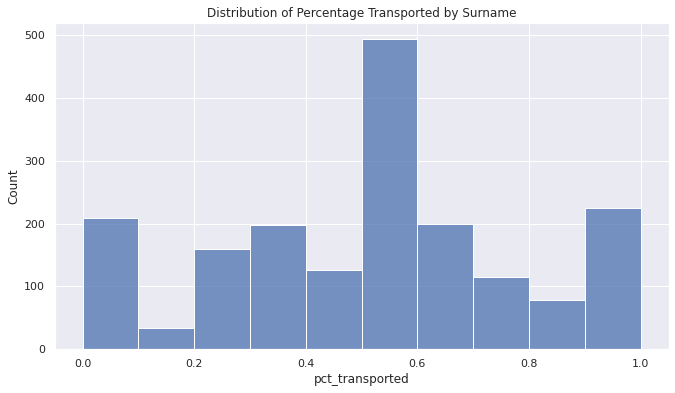

In [48]:
(
    sns.histplot(surname_transported_df[surname_transported_df['totalPassengers'] > 1]['pct_transported'], bins=10)
    .set(title='Distribution of Percentage Transported by Surname')
)
plt.show()

## Write New Properties
Write `totalPassengers` and `pctTransported` to Surname nodes.

In [49]:
# pass dataframe as list of dictionaries 
gds.run_cypher('''
               UNWIND $surname_transported AS item
               MATCH (s:Surname{id:item.surname})
               SET 
                  s.totalPassengers = item.totalPassengers,
                  s.pctTransported = item.pct_transported
              ''', {'surname_transported': surname_transported_df.to_dict('records')})

""


# Analysis of Group Nodes

## Percentage of Group Transported

In [51]:
group_transported_df = gds.run_cypher('''
  MATCH (p:Passenger)-[:MEMBER]->(g:Group)
  WITH
      g.id as group_id,
      g.Group_Size AS group_size,
      COUNT(CASE WHEN p.transported=True THEN 1 END) AS transported
  RETURN
    group_id,
    group_size,
    transported,
    ROUND(toFloat(transported)/toFloat(group_size), 3) AS pct_transported
  ORDER BY group_size DESC
''')

In [52]:
# top five groups sorted by transported passenger count
group_transported_df.sort_values('transported', ascending=False).head()

,group_id,group_size,transported,pct_transported
41,6030,7.0,7,1.000
64,6139,6.0,6,1.000
30,3850,7.0,6,0.857
62,5812,6.0,6,1.000
60,4663,6.0,6,1.000


In [53]:
print('count of groups with all members transported:')
group_transported_df[group_transported_df['pct_transported'] == 1].shape[0]

count of groups with all members transported:


378

In [54]:
# transported statistical distribution
gen_apoc_stats(df=group_transported_df, col='transported')

count    1412.00
mean        1.56
std         1.15
min         0.00
25%         1.00
50%         1.00
75%         2.00
90%         3.00
95%         4.00
99%         5.00
max         7.00
Name: transported, dtype: float64

In [55]:
# transported statistical distribution
gen_apoc_stats(df=group_transported_df, col='pct_transported')

count    1412.00
mean        0.56
std         0.34
min         0.00
25%         0.33
50%         0.50
75%         1.00
90%         1.00
95%         1.00
99%         1.00
max         1.00
Name: pct_transported, dtype: float64

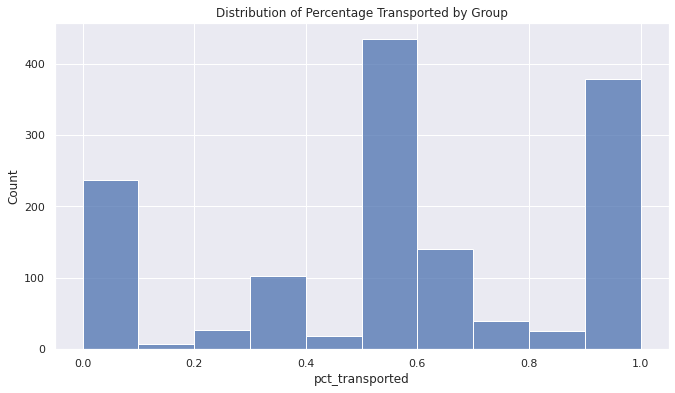

In [56]:
(
    sns.histplot(group_transported_df['pct_transported'], bins=10)
    .set(title='Distribution of Percentage Transported by Group')
)
plt.show()

## Write New Properties

In [57]:
# pass dataframe as list of dictionaries 
gds.run_cypher('''
               UNWIND $group_transported AS item
               MATCH (g:Group{id:item.group_id})
               SET 
                  g.transportedMembers = item.transported_members,
                  g.pctTransported = item.pct_transported
              ''', {'group_transported': group_transported_df.to_dict('records')})

""


# Cabins

## Percentage of Cabin Transported

In [58]:
cabin_transported_df = gds.run_cypher('''
  MATCH (p:Passenger)-[:ASSIGNED]->(c:Cabin)
    WHERE c.id <> 'F999P'
  WITH
      c.id as cabin_id,
      COUNT(p) AS assignedPassengers,
      COUNT(CASE WHEN p.transported=True THEN 1 END) AS transported
  RETURN
    cabin_id,
    assignedPassengers,
    transported,
    ROUND(toFloat(transported)/toFloat(assignedPassengers), 3) AS pct_transported
  ORDER BY assignedPassengers DESC
''')

In [59]:
# sorted by transported passenger count
cabin_transported_df.sort_values('transported', ascending=False).head()

,cabin_id,assignedPassengers,transported,pct_transported
12,G981S,7,7,1.000
2,B183S,7,6,0.857
38,G943S,6,6,1.000
40,C230S,6,6,1.000
8,B82S,7,6,0.857


In [60]:
print('count of cabins where all members transported:')
cabin_transported_df[cabin_transported_df['pct_transported'] == 1].shape[0]

count of cabins where all members transported:


2768

In [61]:
print('count of multi-passenger cabins where all members transported:')
cabin_transported_df[(cabin_transported_df['assignedPassengers'] > 1) & 
                     (cabin_transported_df['pct_transported'] == 1)].shape[0]

count of multi-passenger cabins where all members transported:


383

In [62]:
# transported statistical distribution -- multi-passenger cabins
gen_apoc_stats(df=cabin_transported_df[(cabin_transported_df['assignedPassengers'] > 1)], col='transported')

count    1186.00
mean        1.64
std         1.14
min         0.00
25%         1.00
50%         2.00
75%         2.00
90%         3.00
95%         4.00
99%         5.00
max         7.00
Name: transported, dtype: float64

In [63]:
# transported statistical distribution -- multi-passenger cabins
gen_apoc_stats(df=cabin_transported_df[(cabin_transported_df['assignedPassengers'] > 1)], col='pct_transported')

count    1186.00
mean        0.60
std         0.34
min         0.00
25%         0.50
50%         0.50
75%         1.00
90%         1.00
95%         1.00
99%         1.00
max         1.00
Name: pct_transported, dtype: float64

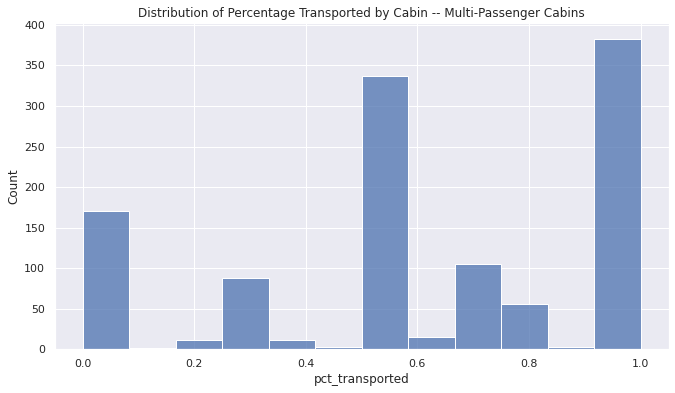

In [64]:
(
    sns.histplot(cabin_transported_df[cabin_transported_df['assignedPassengers'] > 1]['pct_transported'])
    .set(title='Distribution of Percentage Transported by Cabin -- Multi-Passenger Cabins')
)
plt.show()

## Write pct_transported to Group Nodes

In [65]:
# pass dataframe as list of dictionaries 
gds.run_cypher('''
               UNWIND $cabin_transported AS item
               MATCH (c:Cabin{id:item.cabin_id})
               SET 
                  c.assignedPassengers = item.assignedPassengers,
                  c.transportedPassengers = item.transported,
                  c.pctTransported = item.pct_transported
              ''', {'cabin_transported': cabin_transported_df.to_dict('records')})

""


# Revisit Path Exploration with New Node Features
*Explore path where nearly all passengers involved were transported. One observation is that Surnames seem play a major role as bridges between smaller group- and cabin-based communities of passengers.*

In [ ]:
'''
MATCH x=(c:Cabin)<-[:ASSIGNED]-(p:Passenger)-[HAS_SURNAME]->(s:Surname)-[IN_GROUP]->(g:Group)
WHERE 
    s.id <> 'NoSurname' AND
    s.pctTransported > 0.8 AND
    g.Group_Size > 5 AND
    g.pctTransported > 0.8 AND
    p.transported=True AND
    c.id <> 'F999P' 
RETURN x 
LIMIT 250
'''

# Project Monopartite Graph
Collapse Surnames and Groups into a graph containing only Surname nodes with edges representing shared group membership.



In [18]:
gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,"{'p99': 3, 'min': 1, 'max': 4, 'mean': 1.271186440677966, 'p90': 2, 'p50': 1, 'p999': 4, 'p95': 2, 'p75': 1}",surname_group,neo4j,2352 KiB,2409002,472,600,{},0.002699,2022-10-27T17:35:24.730193000+00:00,2022-10-27T17:35:24.722565000+00:00,"{'graphProperties': {}, 'relationships': {'__ALL__': {'weight': 'Float (DefaultValue(NaN), PERSISTENT, Aggregation.NONE)'}}, 'nodes': {'__ALL__': {}}}"


In [17]:
# if necessary, get the graph as a variable
g_surname_group = gds.graph.get('surname_group')

In [ ]:
# # if necessary drop existing graph
# gds.graph.drop(g_surname_group)

In [40]:
g_surname_group, surname_group_desc = gds.graph.project.cypher(
  graph_name='surname_group',
  node_spec = ''' 
              MATCH (s:Surname)-[:IN_GROUP]->(g:Group)
              WHERE
                EXISTS { (s)-[:IN_GROUP]->(g:Group)<-[:IN_GROUP]-() }
              RETURN ID(s) AS id
              ''',
  relationship_spec = ''' 
                      MATCH (p:Passenger)-[:HAS_SURNAME]->(x:Surname)-[:IN_GROUP]->(g:Group)<-[:IN_GROUP]-(y:Surname)
                      RETURN 
                        id(x) AS source, 
                        id(y) AS target,
                        COUNT(p) AS weight
                      ''')

In [41]:
pd.DataFrame(surname_group_desc)

,0
nodeQuery,MATCH (s:Surname)-[:IN_GROUP]->(g:Group)\n WHERE\n EXISTS { (s)-[:IN_GROUP]->(g:Group)<-[:IN_GROUP]-() }\n RETURN ID(s) AS id
relationshipQuery,"MATCH (p:Passenger)-[:HAS_SURNAME]->(x:Surname)-[:IN_GROUP]->(g:Group)<-[:IN_GROUP]-(y:Surname)\n RETURN \n id(x) AS source, \n id(y) AS target,\n COUNT(p) AS weight"
graphName,surname_group
nodeCount,472
relationshipCount,600
projectMillis,111


## Weighted Degree Centrality

In [42]:
surname_centrality = gds.degree.stats(G=g_surname_group,
                                      relationshipWeightProperty='weight')
pd.DataFrame(surname_centrality)

,0
centralityDistribution,"{'p99': 26.00011444091797, 'min': 1.0, 'max': 32.00023651123047, 'mean': 6.4661205097780385, 'p90': 12.000053405761719, 'p50': 5.000022888183594, 'p999': 32.00023651123047, 'p95': 16.00011444091797, 'p75': 8.000053405761719}"
postProcessingMillis,31
preProcessingMillis,0
computeMillis,1
configuration,"{'jobId': 'caf1901c-d4e6-4edc-bebf-9b4a9dfac27f', 'orientation': 'NATURAL', 'relationshipWeightProperty': 'weight', 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'concurrency': 4}"


In [43]:
pd.DataFrame(surname_centrality)[0]['centralityDistribution']

{'p99': 26.00011444091797,
 'min': 1.0,
 'max': 32.00023651123047,
 'mean': 6.4661205097780385,
 'p90': 12.000053405761719,
 'p50': 5.000022888183594,
 'p999': 32.00023651123047,
 'p95': 16.00011444091797,
 'p75': 8.000053405761719}

In [47]:
_ = gds.degree.write(G=g_surname_group, 
                     relationshipWeightProperty='weight',
                     writeProperty='surnameWeightedDegreeCent')

In [48]:
gds.run_cypher('''
  MATCH (s:Surname)
      WHERE s.surnameWeightedDegreeCent IS NOT NULL
  RETURN 
      s.id AS surname,
      s.surnameWeightedDegreeCent AS degreeCent
  ORDER BY degreeCent DESC
  LIMIT 5
''')

,surname,degreeCent
0,Joycerton,32.0
1,Litthews,30.0
2,Josey,30.0
3,Garnes,28.0
4,Pollarkeeks,27.0


In [ ]:
'''
MATCH x=(c:Cabin)<-[:ASSIGNED]-(p:Passenger)-[HAS_SURNAME]->(s:Surname)-[IN_GROUP]->(g:Group)
WHERE s.id = 'Joycerton'
RETURN x
'''

## Weakly Connected Components

In [49]:
# generate statistics for WCC
surname_wcc = gds.wcc.stats(g_surname_group)

In [50]:
surname_wcc = pd.DataFrame(surname_wcc)[0][['componentCount', 'componentDistribution']]

In [51]:
surname_wcc['componentCount']

199

In [52]:
surname_wcc['componentDistribution']

{'p99': 5,
 'min': 2,
 'max': 5,
 'mean': 2.371859296482412,
 'p90': 4,
 'p50': 2,
 'p999': 5,
 'p95': 4,
 'p75': 2}

In [30]:
# write WCCs to graph 
_ = gds.wcc.write(G=g_surname_group, writeProperty='surnameWcc')

In [84]:
# view top components
surname_WCCs = gds.run_cypher('''
  MATCH (s:Surname)
    WHERE s.surnameWcc IS NOT NULL
  RETURN s.surnameWcc AS wcc, 
        COUNT(s.surnameWcc) AS wccSize
  ORDER BY wccSize DESC
''')

surname_WCCs.shape

(199, 2)

In [85]:
surname_WCCs.head(10)

,wcc,wccSize
0,9,5
1,31,5
2,39,5
3,159,5
4,160,5
5,193,5
6,10,4
7,15,4
8,35,4
9,50,4


### View WCCs in Browser

In [ ]:
# returns ~six connected components (vs. 20+ without the wcc element)
'''
MATCH (c:Cabin)<-[:ASSIGNED]-(p:Passenger)-[:HAS_SURNAME]->(s:Surname)-[:IN_GROUP]->(g:Group)
WHERE s.surnameWcc IN [9, 31, 39, 159, 160, 193]
RETURN *
LIMIT 250
'''

## Weighted PageRank

In [53]:
surname_weightedPageRank = gds.pageRank.write(G=g_surname_group, 
                                              relationshipWeightProperty='weight',
                                              writeProperty='surnameWeightedPageRank')

In [54]:
pd.DataFrame(surname_weightedPageRank)[0]['centralityDistribution']

{'p99': 1.4088115692138672,
 'min': 0.43796539306640625,
 'max': 1.8445415496826172,
 'mean': 0.961240594669924,
 'p90': 1.0011119842529297,
 'p50': 0.9612407684326172,
 'p999': 1.8445415496826172,
 'p95': 1.3939876556396484,
 'p75': 0.9612407684326172}

In [55]:
gds.run_cypher('''
  MATCH (s:Surname)
    WHERE s.surnamePageRank IS NOT NULL
  WITH
    s.id AS surname,
    s.surnameWeightedPageRank AS pageRank
  RETURN surname, pageRank
  ORDER BY pageRank DESC
  LIMIT 10
''')

,surname,pageRank
0,Pollarkeeks,1.844543
1,Warrishales,1.844543
2,Stpie,1.716293
3,Josey,1.408808
4,Clumshangs,1.408808
5,Ingent,1.408808
6,Brakepined,1.408808
7,Garden,1.408808
8,Strongers,1.408808
9,Flité,1.408808


In [ ]:
'''
MATCH x=(c:Cabin)<-[:ASSIGNED]-(p:Passenger)-[HAS_SURNAME]->(s:Surname)-[IN_GROUP]->(g:Group)
WHERE s.id IN ['Pollarkeeks', 'Warrishales', 'Stpie']
RETURN x
'''